## Import and Defs

In [4]:
import utility_module_2_v_3 as uu
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from numpy import meshgrid
import geopandas as gpd 
import pandas as pd 

from geopy.geocoders import Nominatim
from tqdm import tqdm
import indices_no_leap as ii

In [5]:
def getclosest_ij(lats,lons,latpt,lonpt):
    dis_sq1=(lats-latpt)**2
    dis_sq2=(lons-lonpt)**2
    
    minidex_lat=dis_sq1.argmin()
    minidex_lon=dis_sq2.argmin()
    
    return minidex_lon,minidex_lat

def extract_regions(data_input,lat_obs,lon_obs):
    
    data_to_indices = []
    for citer , address in enumerate(['Kolkata','Mumbai','New Delhi', 'Chennai']):
        # geolocator = Nominatim(user_agent="Your_Name")
        # location = geolocator.geocode(address)
        

        lat_lon_cities = [[22.5726, 88.363],
        [19.0760, 72.877],
        [28.7041, 77.102],
        [13.0827, 80.270],]
        

        [ind_lon,ind_lat] =getclosest_ij(lat_obs.data,lon_obs.data,lat_lon_cities[citer][0],lat_lon_cities[citer][1])
        data_to_indices.append(data_input[:, ind_lat,ind_lon])


    regional_boxes = [[72,29,77,25],[77,24,84,18],[87,30,97,21]]

    for co_ords in regional_boxes:

        lat_index_123 = np.logical_and(lat_obs >= co_ords[3], lat_obs <= co_ords[1])
        lon_index_123 = np.logical_and(lon_obs >= co_ords[0], lon_obs <= co_ords[2])

        data_to_indices.append(np.nanmean(data_input[:, lat_index_123,:][:,:,lon_index_123],axis=(1,2)))

    data_to_indices.append(np.nanmean(data_input,axis=(1,2)))
    
    # print(np.array(data_to_indices).shape)
    data_indices = {}
    for index_name in ["P_ann","IAV","R20mm","Rx1day", "CDD","R99p"]:
        data_indices[index_name] =[]   
    for itera, data_temp in enumerate(data_to_indices):
        
        for index_name,func in zip(["P_ann","IAV","R20mm","Rx1day", "CDD","R99p"],
                                   [ii.sum_annualy, ii.sum_annualy, ii.R20mm_annualy,ii.Rx1day_annualy,ii.CDD_annualy,ii.R99p_annualy]):
            # print(itera,data_temp.shape,data_temp.shape[0]//365)
            if index_name == "IAV":
                # print("Var loop entered.")
                data_indices[index_name].append(np.nanvar(func(data_temp,data_temp.shape[0]//365)))

            else:
                # print("NN loop entered.")

                data_indices[index_name].append(np.nanmean(func(data_temp,data_temp.shape[0]//365)))
        
    # print("Inxde",np.array(data_indices).shape,np.array(data_indices[index_name]).shape) 
    return data_indices

In [3]:
gcm_list = ['CanESM2','GFDL_CM3','MIROC_ESM','MRI_ESM1','ACCESS1_0','NorESM1_M','CM5A_LR','CNRM_CM5','MPI_ESM_MR']
N_esm =len(gcm_list)
index_list = ['CDD','Rx1day','R20mm','R99p']
N_random = 10
map_bounds=[65, 40, 100, 5]
output_figname = ''
path_out_IMD = '/home/vikram/BCSD_data/India_P_BCSDd'+output_figname
ind_shape = gpd.read_file('/home/vikram/BCSD_Shapefiles/ind.shp')


## Import data

### For cities (all ESMs)

In [4]:

gcm_meta=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_list[0]+'.npy',allow_pickle=True)
Nyears_train = gcm_meta.item()['Nyears_train']
N_future_start = 2045-2006
st=gcm_meta.item()['st']
en=gcm_meta.item()['en']

lat_obs=gcm_meta.item()['lat_obs']
lat_gcm_01=gcm_meta.item()['lat_gcm']
lon_obs=gcm_meta.item()['lon_obs']
lon_gcm_01=gcm_meta.item()['lon_gcm']
mask=gcm_meta.item()['mask']

N1=lat_obs.shape[0]
N2=lon_obs.shape[0]


data_all_final_observations =[]

imd_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_obs_imd_pred.npy'))[365*Nyears_train:]
data_all_final_observations.append(extract_regions(imd_test,lat_obs,lon_obs))

data_all_final_gcms =[]
data_all_final_gcms_future =[]
data_all_final_gcms_future2 =[]
data_all_final_bcs_gcms =[]
data_all_final_bcs_gcms_future =[]
data_all_final_bcs_gcms_future2 =[]
data_all_final_random_fields =[]

for gcm_name in tqdm(gcm_list):
    
    gcm_meta=np.load(path_out_IMD + '/bcsd_imd_metadata_'+gcm_name+'.npy',allow_pickle=True)
    lat_gcm_01=gcm_meta.item()['lat_gcm']
    lon_gcm_01=gcm_meta.item()['lon_gcm']

    gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_imd_pred.npy'))[365*Nyears_train:]
    data_gf_test=np.zeros(imd_test.shape)
    for i in range(gcm_test.shape[0]):
        data_gf_test[i,:,:]=uu.regrid(gcm_test[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
    data_all_final_gcms.append(extract_regions(data_gf_test,lat_obs,lon_obs))
    
    gcm_future=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_future.npy'))[365*N_future_start:]
    data_gf_future=np.zeros([gcm_future.shape[0],imd_test.shape[1],imd_test.shape[2]])
    for i in range(data_gf_future.shape[0]):
        data_gf_future[i,:,:]=uu.regrid(gcm_future[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
    data_all_final_gcms_future.append(extract_regions(data_gf_future,lat_obs,lon_obs))

    
    gcm_future=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/data_gcm_'+gcm_name+'_future.npy'))[:365*N_future_start]
    data_gf_future=np.zeros([gcm_future.shape[0],imd_test.shape[1],imd_test.shape[2]])
    for i in range(data_gf_future.shape[0]):
        data_gf_future[i,:,:]=uu.regrid(gcm_future[i,:,:],lat_gcm_01,lon_gcm_01,lat_obs,lon_obs)
    data_all_final_gcms_future2.append(extract_regions(data_gf_future,lat_obs,lon_obs))

    out_id='pre_'+gcm_name 
    bcsd_gcm_test=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_historical'+out_id+'.npy'))[365*Nyears_train:]
    data_all_final_bcs_gcms.append(extract_regions(bcsd_gcm_test,lat_obs,lon_obs))
    
    bcsd_gcm_future=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_'+out_id+'.npy'))[365*N_future_start:]
    data_all_final_bcs_gcms_future.append(extract_regions(bcsd_gcm_future,lat_obs,lon_obs))

    bcsd_gcm_future2=uu.correct_nan_inf_neg(np.load(path_out_IMD + '/detrended_BCSD_outputs_'+out_id+'.npy'))[:365*N_future_start]
    data_all_final_bcs_gcms_future2.append(extract_regions(bcsd_gcm_future,lat_obs,lon_obs))

    
for j in tqdm(range(N_random)):
    out_id='pre_rnd_new_'+str(j)  
    bcsd_rnd_test=uu.correct_nan_inf_neg((np.load(path_out_IMD + '/BCSD_outputs_'+out_id+'.npy')))[365*Nyears_train:]
    data_all_final_random_fields.append(extract_regions(bcsd_rnd_test,lat_obs,lon_obs))



100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.31s/it]


### Spatial Maps

In [5]:
##--------------- For CanESM2 -----------------------------##
gcm_name = 'CanESM2'
P_ann_test = np.load("./data_spatial/P_ann_test_hist.npy")
IAV_test = np.load("./data_spatial/IAV_test_hist.npy")/10000
R50mmindic_test = np.load("./data_spatial/R50mmindic_test_hist.npy")
Rx1dayindic_test = np.load("./data_spatial/Rx1dayindic_test_hist.npy")
CDDindic_test = np.load("./data_spatial/CDDindic_test_hist.npy")
R99pindic_test = np.load("./data_spatial/R99pindic_test_hist.npy")

P_ann_test_future = np.load("./data_spatial/P_ann_test_future.npy")
IAV_test_future = np.load("./data_spatial/IAV_test_future.npy")/10000
R50mmindic_test_future = np.load("./data_spatial/R50mmindic_test_future.npy")
Rx1dayindic_test_future = np.load("./data_spatial/Rx1dayindic_test_future.npy")
CDDindic_test_future = np.load("./data_spatial/CDDindic_test_future.npy")
R99pindic_test_future = np.load("./data_spatial/R99pindic_test_future.npy")

mask  = np.load("./data_spatial/mask.npy")
lat_obs = np.load("./data_spatial/lat_obs.npy")
lon_obs = np.load("./data_spatial/lon_obs.npy")


data_to_plot_hist = [P_ann_test,
                IAV_test,
                R50mmindic_test,
                Rx1dayindic_test,
                CDDindic_test,
                R99pindic_test]

data_to_plot_future = [P_ann_test_future,
                IAV_test_future,
                R50mmindic_test_future,
                Rx1dayindic_test_future,
                CDDindic_test_future,
                R99pindic_test_future]


# Plot

## Defining plot parameters

In [7]:

y_limits=[[0,2000],
          [0,20],
          [0,50],
          [0,200],
          [0,200],
          [0,200],
          [0,200]]

labels=['mm','$ 10^4 mm^2$','# of days','mm','# of days','mm']

cmaps = ['RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r']


ind_names =["P_ann","IAV",'R20mm','Rx1day', 'CDD','R99p',]

ylims_list = [[[0,2500],[0,3000],[0,2000],[0,3000],
         [0,1000],[0,1800],[0,3000],[0,2000]],
        [[0,150000],[0,300000],[0,100000],[0,450000],
         [0,50000],[0,150000],[0,150000],[0,32000]],
        [[0,40],[0,50],[0,18],[0,30],
         [0,6],[0,20],[0,40],[0,3]],
        [[0,150],[0,200],[0,100],[0,200],
         [0,75],[0,100],[0,80],[0,30]],
        [[0,100],[0,250],[0,200],[0,200],
         [0,250],[0,150],[0,60],[0,50]],
        [[0,250],[0,250],[0,150],[0,320],
         [0,100],[0,180],[0,250],[0,100]]]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']

indices_meta = pd.DataFrame(list(zip(ind_names,y_limits,ylims_list,labels, cmaps,data_to_plot_hist,data_to_plot_future)),
             columns = ["name","y_limits", "ylims_cities","labels","cmaps","data_hist","data_future"])

indices_meta.set_index("name",inplace=True)


markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']
data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 
                           'Western India', 'Central India' , 'NE India','All India']


NameError: name 'gcm_name' is not defined

## Plot Historical

P_ann::Kolkata -652.6748623871185 -198.75421481579406 -237.06949966244792 38.31528484665387
P_ann::Mumbai -1292.9045627958349 -746.5316307873554 -780.2427415651425 33.7111107777871
P_ann::New Delhi 138.63333139180554 470.4384522271281 22.31818785674625 448.12026437038185
P_ann::Chennai -405.7163081554364 -59.630454505364014 605.7333623205329 -665.363816825897
P_ann::Western India 319.4577868242343 601.7981301199899 117.03036016779402 484.76776995219586
P_ann::Central India -410.0209355410516 -126.43205340242207 -126.2369714133531 -0.19508198906896723
P_ann::NE India -1350.1744512399148 -1028.965593907075 -228.47078060717217 -800.4948132999027
P_ann::All India -539.4802008839459 -230.99245647845987 35.820521202605505 -266.8129776810654
IAV::Kolkata -77926.20492121052 -46967.21488416804 -93322.07464489111 46354.85976072308
IAV::Mumbai -231906.2792615269 -168072.11351007066 -235502.30554315326 67430.1920330826
IAV::New Delhi -8146.983721314002 34911.360848345554 -29170.978284892175 64082.

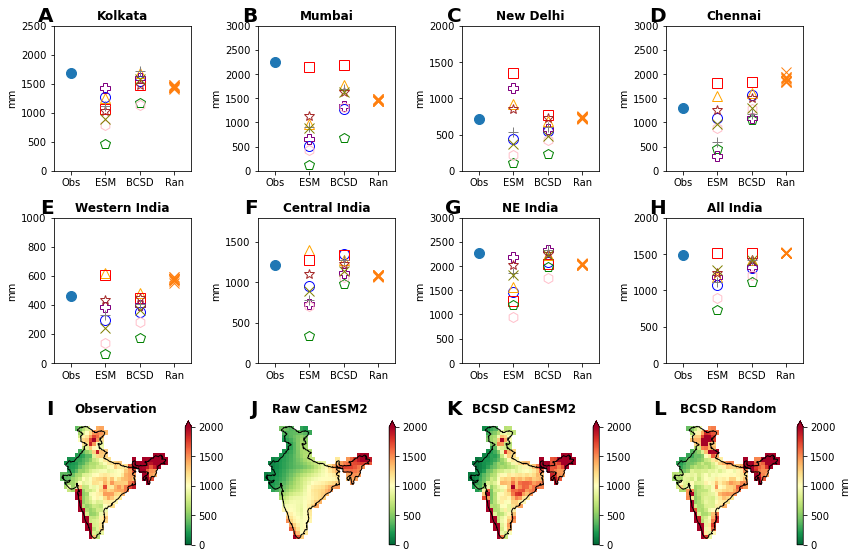

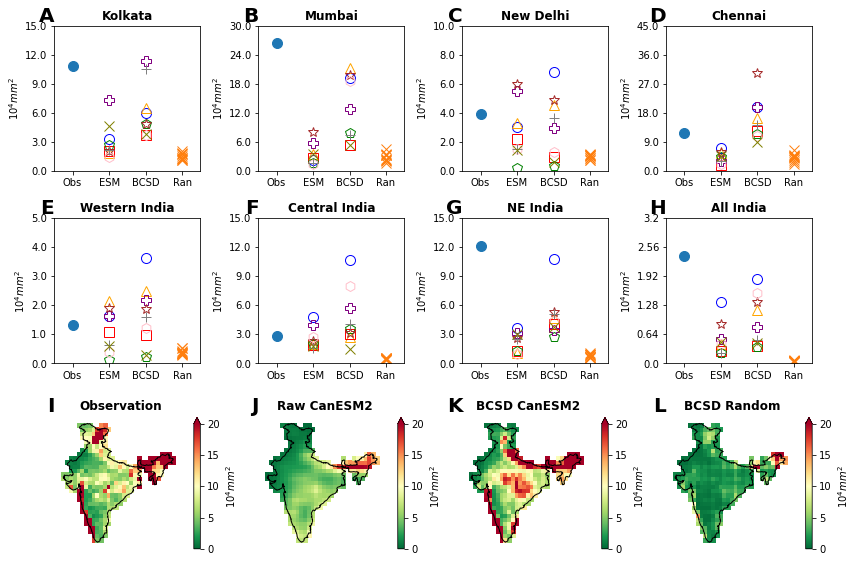

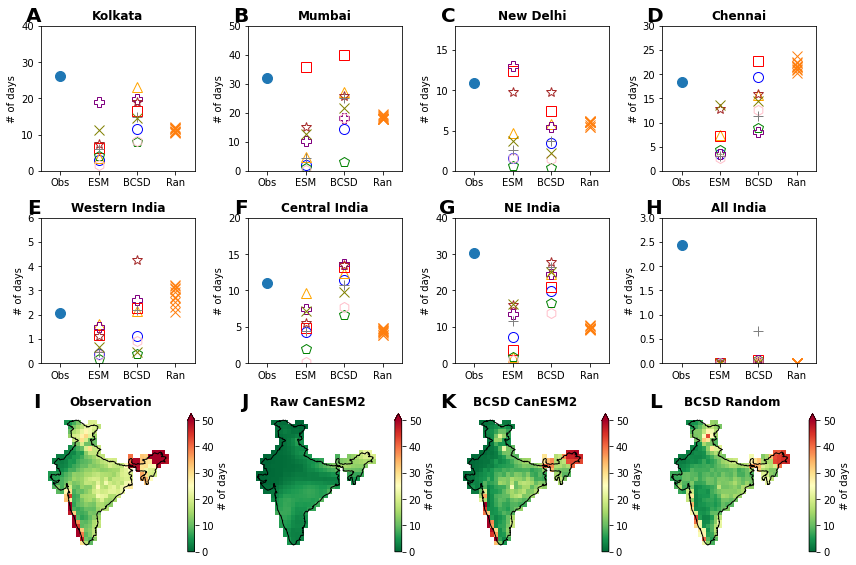

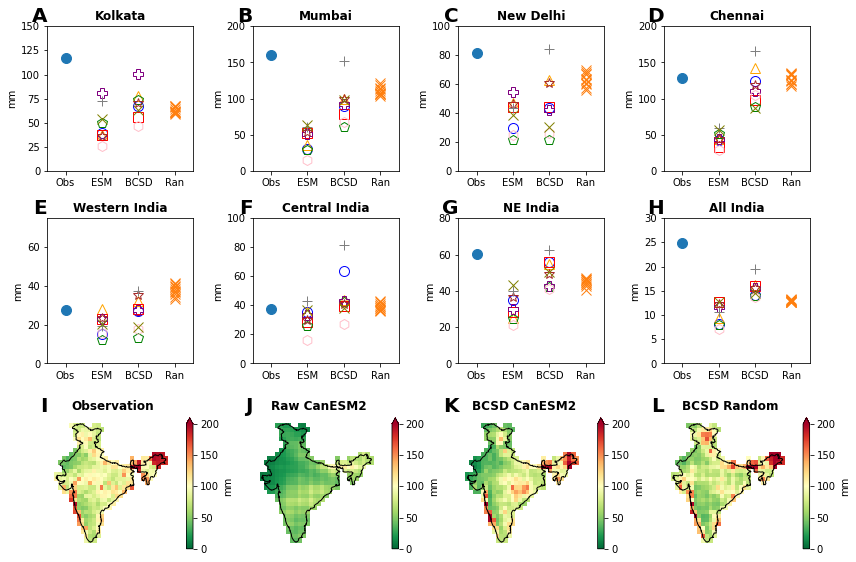

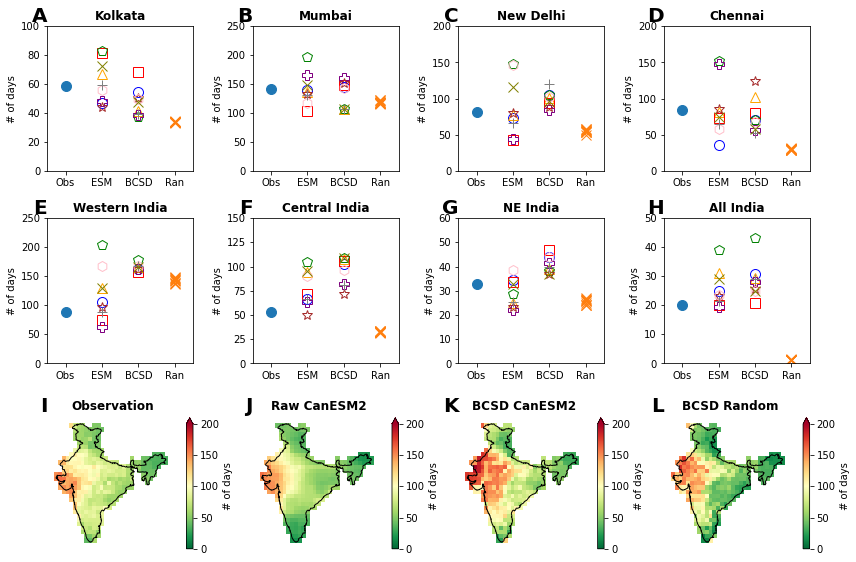

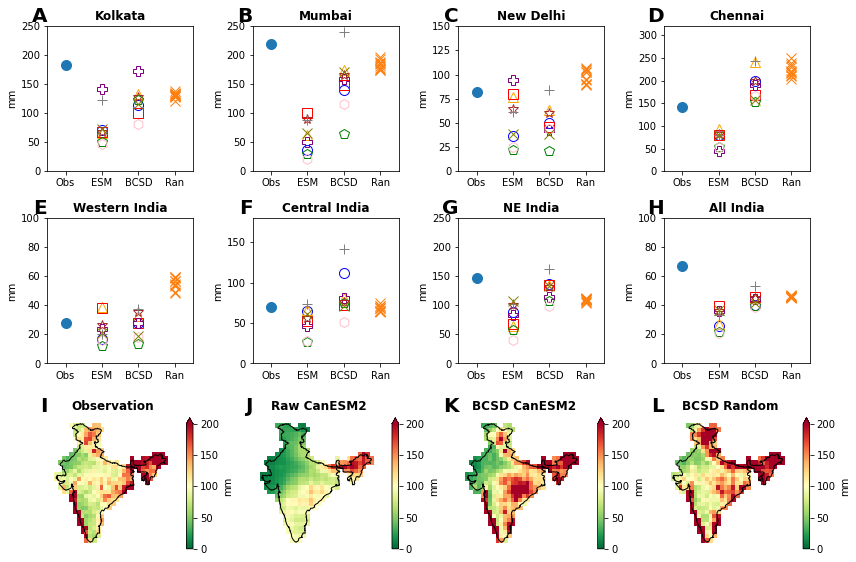

In [7]:


for index in ind_names:
    plt.figure(figsize = (12,8))
    
    ind_to_plot = index    
    data_plot= indices_meta.loc[ind_to_plot,'data_hist']
    v_min= indices_meta.loc[ind_to_plot,'y_limits'][0]
    v_max= indices_meta.loc[ind_to_plot,'y_limits'][1]
    cmap = indices_meta.loc[ind_to_plot,'cmaps']
    label = indices_meta.loc[ind_to_plot,'labels']
    
    gcm_data_indic_for_values = []
    bcgcm_data_indic_for_values = []
    bcrandom_data_indic_for_values = []

    for pliter in range(8):
        ylims = indices_meta.loc[index,'ylims_cities']
        
        ax = plt.subplot(3,4,pliter +1)
        plt.plot(1,data_all_final_observations[0][index][pliter], marker = markers[0],markersize = 10,linestyle = 'None')

        for gi in range(N_esm):
            plt.plot( 2 , data_all_final_gcms[gi][index][pliter],
                     markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
            gcm_data_indic_for_values.append(data_all_final_gcms[gi][index][pliter])
            
            plt.plot( 3 , data_all_final_bcs_gcms[gi][index][pliter],
                     markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
            bcgcm_data_indic_for_values.append(data_all_final_bcs_gcms[gi][index][pliter])
            
        plt.plot(list(4 for x in range(N_random)) ,list(data_all_final_random_fields[x][index][pliter] for x in range(N_random)),
             markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = "Random")
        bcrandom_data_indic_for_values = list(data_all_final_random_fields[x][index][pliter] for x in range(N_random))
        plt.xticks(range(1,5),["Obs","ESM","BCSD","Ran"])
        plt.title(data_to_indices_label[pliter],fontweight = 'bold')

        plt.xlim([0.5,4.5])
        plt.ylim(ylims[pliter])
        if index == "IAV":
            plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
        else:
            pass
        lxx, lyy = 0,1
        plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')

        plt.ylabel(label)
        
        
        print(index + "::" +  data_to_indices_label[pliter],
              np.mean(np.array(gcm_data_indic_for_values)) - data_all_final_observations[0][index][pliter],
              np.mean(np.array(bcgcm_data_indic_for_values)) - data_all_final_observations[0][index][pliter],
              np.mean(np.array(bcrandom_data_indic_for_values)) - data_all_final_observations[0][index][pliter],
              np.mean(np.array(bcgcm_data_indic_for_values)) - np.mean(np.array(bcrandom_data_indic_for_values)),
             )
    # plt.legend()
    for cc in range(4):
        ax=plt.subplot(3,4,cc+9)

        plt.pcolor(lon_obs,lat_obs,
                   np.ma.masked_array(data_plot[cc,:,:],mask),
                   vmin = v_min,
                   vmax = v_max,
                   cmap = cmap
                  )
        plt.colorbar(extend = 'max',fraction=0.045,label =label)
        ind_shape.plot(ax=ax,fc = 'none' )
        plt.title(titlesx[cc],fontweight = 'bold')
        plt.xticks([]),plt.yticks([])
        plt.axis('off')
        plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')

        
        
    plt.tight_layout()
    # plt.savefig("./plots/" + index + "_hist.svg", facecolor = 'w')
    # plt.savefig("./plots/" + index + "_hist.png", facecolor = 'w')



## Plot Future

<Figure size 720x288 with 0 Axes>

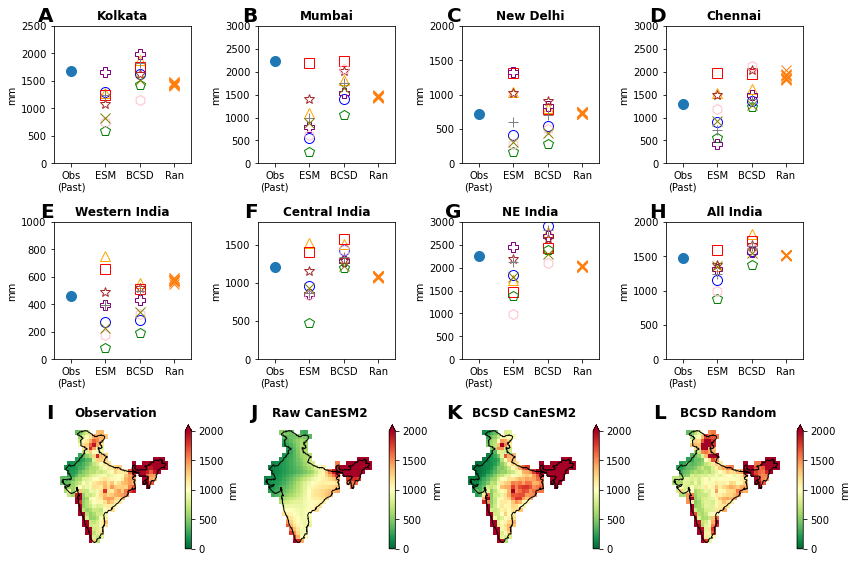

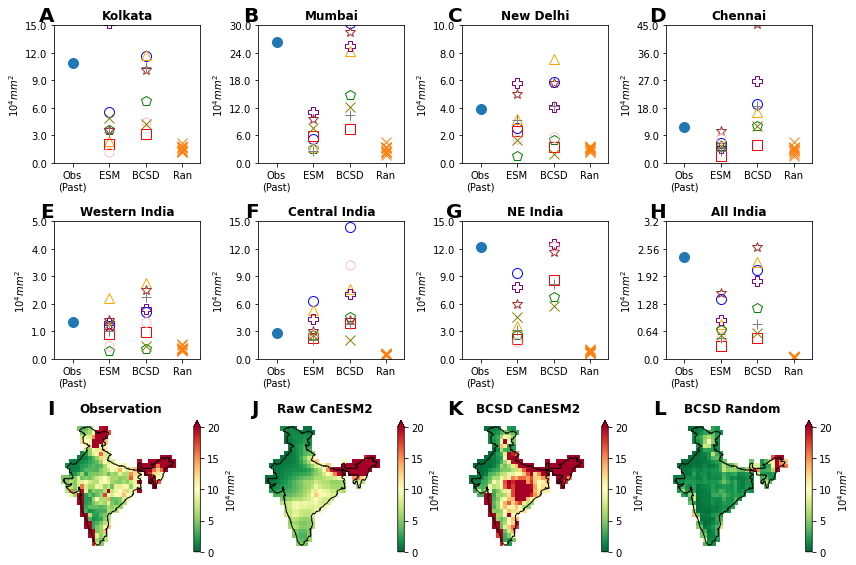

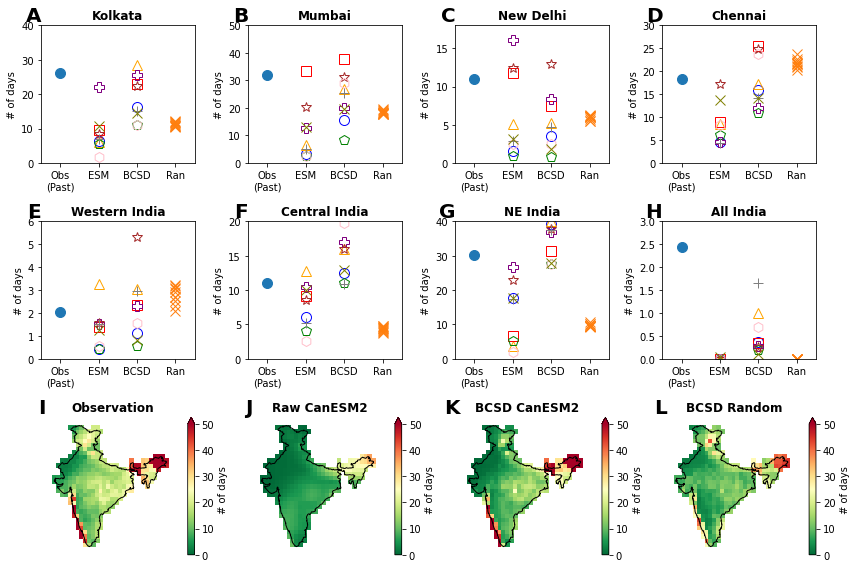

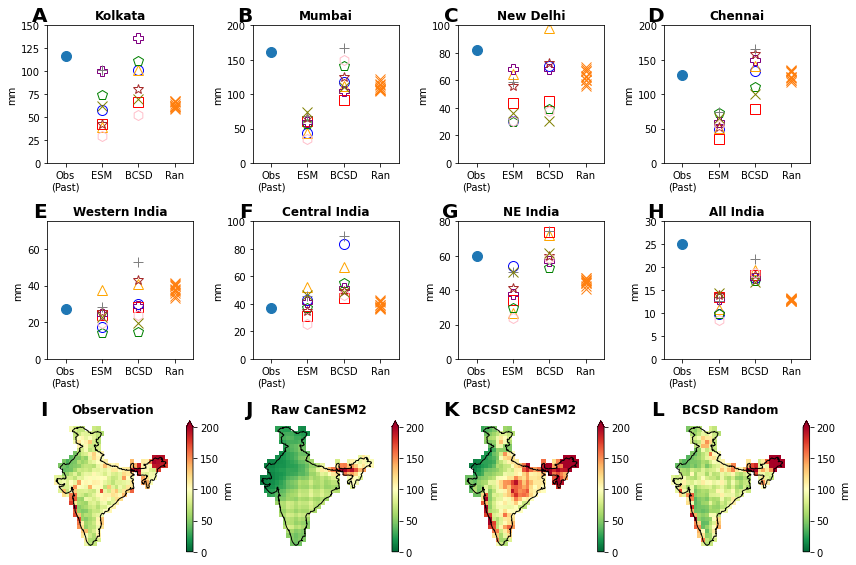

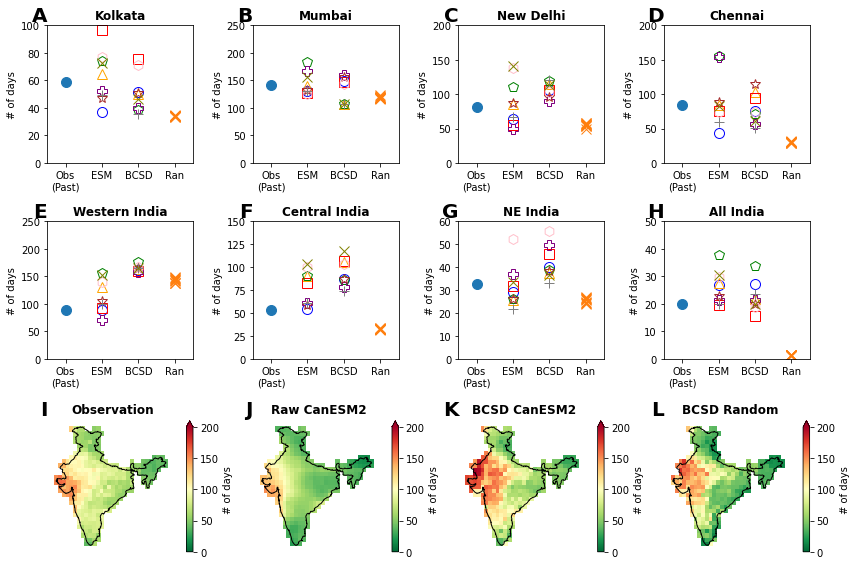

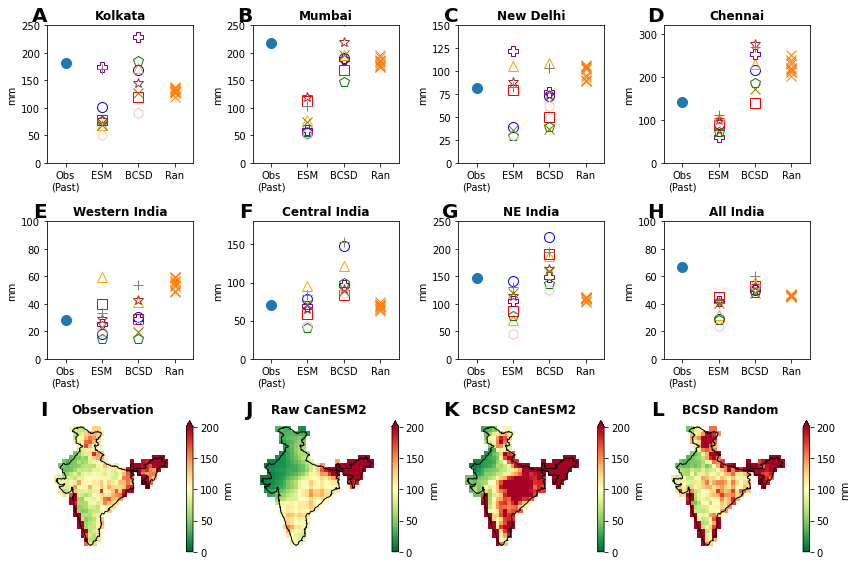

In [8]:
plt.figure(figsize = (10,4))

for index in ind_names:
    plt.figure(figsize = (12,8))
    
    ind_to_plot = index    
    data_plot= indices_meta.loc[ind_to_plot,'data_future']
    v_min= indices_meta.loc[ind_to_plot,'y_limits'][0]
    v_max= indices_meta.loc[ind_to_plot,'y_limits'][1]
    cmap = indices_meta.loc[ind_to_plot,'cmaps']
    label = indices_meta.loc[ind_to_plot,'labels']
    ylims = indices_meta.loc[index,'ylims_cities']

    for pliter in range(8):

        ax =plt.subplot(3,4,pliter +1)
        plt.plot(1,data_all_final_observations[0][index][pliter], marker = markers[0],markersize = 10,linestyle = 'None',label = "Observed")

        for gi in range(N_esm):

            plt.plot( 2 , data_all_final_gcms_future[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi],
                    color = colors[gi])

            plt.plot( 3 , data_all_final_bcs_gcms_future[gi][index][pliter],
                     markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi],color = colors[gi])

        plt.plot(list(4 for x in range(N_random)) ,list(data_all_final_random_fields[x][index][pliter] for x in range(N_random)),
             markers[gi],markersize = 10,linestyle = 'None',mfc='none',label ="Random")


        plt.xticks(range(1,5),["Obs\n(Past)","ESM","BCSD","Ran"])
        plt.title(data_to_indices_label[pliter],fontweight = 'bold')

        plt.xlim([0.5,4.5])
        plt.ylim(ylims[pliter])
        if index == "IAV":
            plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
        else:
            # plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
            pass
        lxx, lyy = 0,1
        plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')
        plt.ylabel(label)
    for cc in range(4):
        ax=plt.subplot(3,4,cc+9)

        plt.pcolor(lon_obs,lat_obs,
                   np.ma.masked_array(data_plot[cc,:,:],mask),
                   vmin = v_min,
                   vmax = v_max,
                   cmap = cmap
                  )
        plt.colorbar(extend = 'max',fraction=0.045,label =label)
        ind_shape.plot(ax=ax,fc = 'none' )
        plt.title(titlesx[cc],fontweight = 'bold')
        plt.xticks([]),plt.yticks([])
        plt.axis('off')
        plt.text(lxx, lyy, chr(65+8+cc), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
            fontsize=20,color='k')

    plt.tight_layout()
    # plt.savefig("./plots/" + index + "_future.svg",facecolor = 'w')
    # plt.savefig("./plots/" + index + "_future.png",facecolor = 'w')



## Plot legend

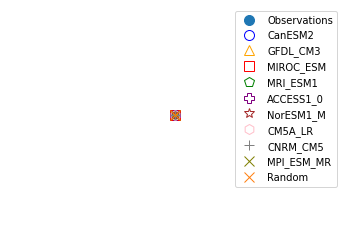

In [9]:
plt.plot(2,2, marker = markers[0],markersize = 10,linestyle = 'None',label = "Observations")

for gi in range(N_esm):
    plt.plot( 2 , 2, markers[gi],color = colors[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
plt.plot(2,2, markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = "Random")
plt.axis('off')
plt.legend()    
plt.savefig("./plots/legend.svg", facecolor = 'w')


## Plot Map

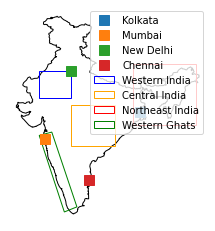

In [29]:
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
import geopandas as gpd
from geopy.geocoders import Nominatim
import numpy as np

markers=['o','^','s','p','P','*','h','+','x','X','D']
colors= ['blue','orange','red','green','purple','brown','pink','gray','olive','cyan','k']


lats,lons = (np.arange(0,40,1),np.arange(65,100,1))
XX12,YY12 = np.meshgrid(lons,lats)

fig, ax = plt.subplots()

for address in ['Kolkata','Mumbai','New Delhi', 'Chennai']:
    geolocator = Nominatim(user_agent="Your_Name")
    location = geolocator.geocode(address)
    [ind_lon,ind_lat] = getclosest_ij(lats,lons,location.latitude,location.longitude)
    plt.plot(lons[ind_lon],lats[ind_lat],marker='s',linestyle ='none',markersize= 10,label =address)

ind =gpd.read_file('/home/vikram/BCSD_Shapefiles/ind.shp')
ind.plot(ax=ax,facecolor="none")

regional_boxes = [[72,29,77,25],[77,24,84,18],[87,30,97,21]]
regions = ['Western India', 'Central India' , 'Northeast India']
for citer,co_ords in enumerate(regional_boxes):
    ax.add_patch(Polygon([(co_ords[0],co_ords[1]),
                           (co_ords[0],co_ords[3]),
                           (co_ords[2],co_ords[3]),
                           (co_ords[2],co_ords[1])],facecolor='none',edgecolor= colors[citer],label =regions[citer]))
    
    
ax.add_patch(Polygon([(74,20),
                        (72,19.5),
                        (76,8.25),
                        (78,9),],facecolor='none',edgecolor= colors[3],label ="Western Ghats"))

    
plt.legend()
plt.axis('off')
plt.savefig("./plots/legend2wg.svg", facecolor = 'w')


# Others

In [ ]:
plt.figure(figsize = (10,4))

N_esm =len(gcm_list)



index=  'R99p'
units = "mm"

ylims = [[0,250],[0,250],[0,150],[0,320],
         [0,100],[0,180],[0,250],[0,100]]



index=  'IAV'
units = "x $10^4$ $mm^2$"


ylims = [[0,150000],[0,300000],[0,100000],[0,450000],
         [0,50000],[0,150000],[0,150000],[0,32000]]


index=  'P_ann'
units = "mm"

ylims = [[0,2500],[0,3000],[0,2000],[0,3000],
         [0,1000],[0,1800],[0,3000],[0,2000]]



index=  'CDD'
units = "# days"
    
ylims = [[0,100],[0,250],[0,200],[0,200],
         [0,250],[0,150],[0,60],[0,50]]
    
    
index=  'Rx1day'
units = "mm"
    
ylims = [[0,150],[0,200],[0,100],[0,200],
         [0,75],[0,100],[0,80],[0,30]]

index=  'R20mm'
units = "# days"
    
ylims = [[0,40],[0,50],[0,18],[0,30],
         [0,6],[0,20],[0,40],[0,3]]
    
    
markers=['o','^','s','p','P','*','h','+','x','X','D']

data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 
                           'Western India', 'Central India' , 'NE India','All India']

# plt.plot( 0,0, 'D',markersize = 10,color ='w',linestyle = 'None',mfc='none',label ='Random Fields')
for pliter in range(8):
    ax = plt.subplot(2,4,pliter +1)
    plt.plot(1,data_all_final_observations[0][index][pliter], marker = markers[0],markersize = 10,linestyle = 'None')

    for gi in range(N_esm):
        plt.plot( 2 , data_all_final_gcms[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 3 , data_all_final_bcs_gcms[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

    plt.plot(list(4 for x in range(N_random)) ,list(data_all_final_random_fields[x][index][pliter] for x in range(N_random)),
         markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
    
    plt.xticks(range(1,5),["Obs","ESM","BCSD","Ran"])
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,4.5])
    plt.ylim(ylims[pliter])
    if index == "IAV":
        plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
    else:
        # plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
        pass
    lxx, lyy = 0,1
    plt.text(lxx, lyy, chr(65+pliter), horizontalalignment='right',verticalalignment='bottom', transform=ax.transAxes,fontweight=800,
        fontsize=20,color='k')

    plt.ylabel(units)
    
plt.tight_layout()
# plt.suptitle("Comparison of " + index + " for bias-corrected results")
plt.suptitle( index )
# plt.savefig("./detrended_future/" + index + ".png", dpi =150, facecolor = 'w')



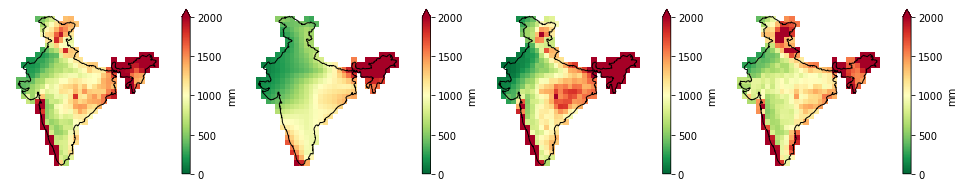

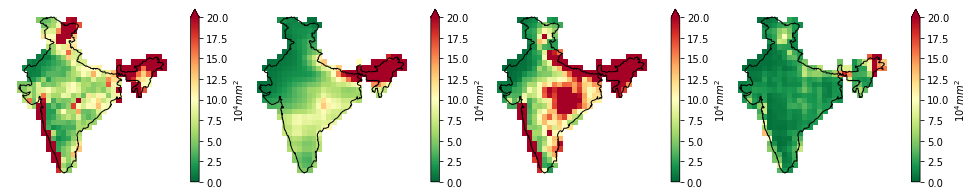

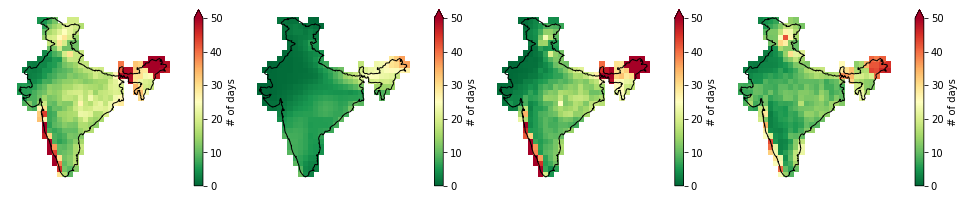

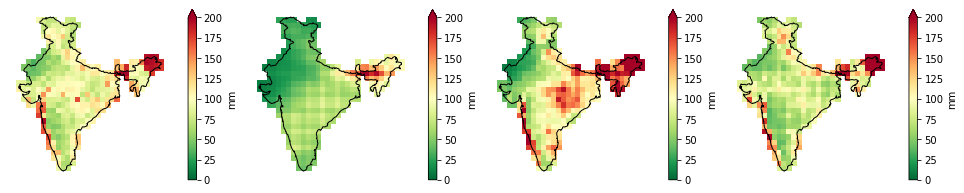

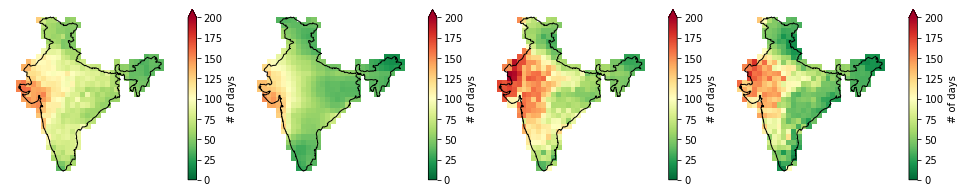

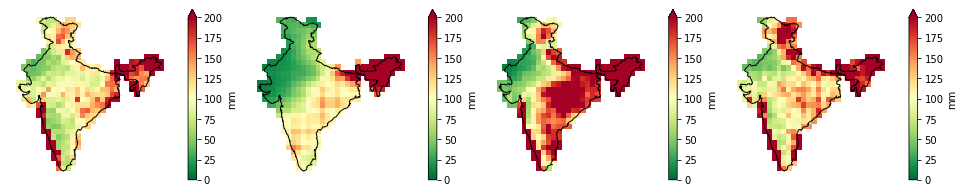

In [150]:

y_limits=[[0,2000],
          [0,20],
          [0,50],
          [0,200],
          [0,200],
          [0,200],
          [0,200]]

labels=['mm','$ 10^4 mm^2$','# of days','mm','# of days','mm']

cmaps = ['RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r','RdYlGn_r']


ind_names =["P_ann","IAV",'R50mm','Rx1day', 'CDD','R99p',]

data_to_plot = [P_ann_test,
                IAV_test,
                R50mmindic_test,
                Rx1dayindic_test,
                CDDindic_test,
                R99pindic_test]

titlesx=['Observation','Raw '+gcm_name,'BCSD '+gcm_name,'BCSD Random']

for ind_to_plot in ind_names:
    plt.figure(figsize=(13.5,3))

    data_plot= indices_meta.loc[ind_to_plot,'data']
    v_min= indices_meta.loc[ind_to_plot,'y_limits'][0]
    v_max= indices_meta.loc[ind_to_plot,'y_limits'][1]
    cmap = indices_meta.loc[ind_to_plot,'cmaps']
    label = indices_meta.loc[ind_to_plot,'labels']

    for cc in range(4):
        ax=plt.subplot(1,4,cc+1)

        plt.pcolor(lon_obs,lat_obs,
                   np.ma.masked_array(data_plot[cc,:,:],mask),
                   vmin = v_min,
                   vmax = v_max,
                   cmap = cmap
                  )
        plt.colorbar(extend = 'max',fraction=0.045,label =label)
        ind_shape.plot(ax=ax,fc = 'none' )
        plt.xticks([]),plt.yticks([])
        plt.axis('off')

    plt.tight_layout()


In [ ]:
plt.figure(figsize = (10,4))
N_esm =len(gcm_list)
N_random = 1
index=  'P_ann'
units = 'mm'

markers=['o','^','s','p','P','*','h','+','x','X','D']


data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 
                           'Western India', 'Central India' , 'NE India','All India']

# plt.plot( 0,0, 'D',markersize = 10,color ='w',linestyle = 'None',mfc='none',label ='Random Fields')
for pliter in range(8):
    plt.subplot(2,4,pliter +1)
    plt.plot(1,data_all_final_observations[0][index][pliter], marker = markers[0],markersize = 10,linestyle = 'None')

    for gi in range(N_esm):
        plt.plot( 2 , data_all_final_gcms[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 3 , data_all_final_bcs_gcms[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 4 , data_all_final_gcms_future[gi][index][pliter],
             markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 5 , data_all_final_bcs_gcms_future[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 6 , data_all_final_gcms_future[gi][index][pliter]-data_all_final_gcms_future2[gi][index][pliter],
             markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 7 , data_all_final_bcs_gcms_future[gi][index][pliter]-data_all_final_bcs_gcms_future2[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])


    plt.plot(list(8 for x in range(N_random)) ,list(data_all_final_random_fields[x][index][pliter] for x in range(N_random)),
         markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
    
    plt.xticks(range(1,9),["Obs","ESM","BC","ESM","BC","d1","d2","Ra"],rotation = 90)
    plt.title(data_to_indices_label[pliter])
    plt.xlim([0,9])
    # if pliter < 4:
    #     plt.ylim([0,200])
    # elif pliter <7:
    #     plt.ylim([0,100])
    # else:
    #     plt.ylim([0,30])
plt.tight_layout()

In [ ]:
plt.figure(figsize = (10,4))
N_esm =len(gcm_list)
N_random = 1

markers=['o','^','s','p','P','*','h','+','x','X','D']


data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 
                           'Western India', 'Central India' , 'NE India','All India']
index=  'R99p'
units = "mm"

ylims = [[60,-60],[60,-60],[60,-60],[60,-60],
        [50,-50],[50,-50],[60,-60],[10,-10]]



index=  'IAV'
units = "x 10000 mm2"


ylims = [[-150000,150000],[0,300000],[0,100000],[0,450000],
         [0,50000],[0,150000],[0,250000],[0,50000]]


index=  'P_ann'
units = "mm"

ylims = [[250,-250],[250,-250],[150,-150],[500,-500],
        [150,-150],[150,-150],[500,-500],[500,-500]]



index=  'CDD'
units = "# days"
    
ylims = [[50,-50],[50,-50],[50,-50],[50,-50],
        [25,-25],[25,-25],[25,-25],[10,-10]]
    
index=  'Rx1day'
units = "mm"
    
ylims = [[25,-25],[25,-25],[25,-25],[25,-25],
        [10,-10],[10,-10],[60,-60],[5,-5]]

index=  'R20mm'
units = "# days"
    
ylims = [[10,-10],[10,-10],[10,-10],[10,-10],
        [10,-10],[10,-10],[10,-10],[1,-1]]
    
    
# plt.plot( 0,0, 'D',markersize = 10,color ='w',linestyle = 'None',mfc='none',label ='Random Fields')
for pliter in range(8):
    plt.subplot(2,4,pliter +1)
    # plt.plot(1,data_all_final_observations[0][index][pliter], marker = markers[0],markersize = 10,linestyle = 'None')

    for gi in range(N_esm):

        plt.plot( 1 , data_all_final_gcms_future[gi][index][pliter]- data_all_final_gcms[gi][index][pliter],
             markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])

        plt.plot( 2 , data_all_final_bcs_gcms_future[gi][index][pliter]-data_all_final_bcs_gcms[gi][index][pliter],
                 markers[gi],markersize = 10,linestyle = 'None',mfc='none',label = gcm_list[gi])
    
    
    plt.xticks(range(1,3),["ESM","BCSD"])
    plt.title(data_to_indices_label[pliter])
    
    plt.xlim([0.5,2.5])
    plt.ylim(ylims[pliter])
    plt.ylabel(units)
    if index == "IAV":
        plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
    else:
        # plt.yticks(np.linspace(ylims[pliter][0],ylims[pliter][1],6),np.linspace(ylims[pliter][0]/10000,ylims[pliter][1]/10000,6))
        pass
plt.tight_layout()
# plt.suptitle("Comparison of " + index + " for bias-corrected results")
plt.suptitle( "Change : " + index )
plt.savefig("./detrended_future/change_" + index + ".png", dpi =150, facecolor = 'w')

In [ ]:
prints(imd_train,imd_test,data_gf_train,data_gf_test,bcsd_gcm_train,bcsd_gcm_test,bcsd_rnd_train,bcsd_rnd_test,data_gf_future)

## Checking imported data

In [ ]:

data_train = [imd_train,data_gf_train,data_gf_future,bcsd_gcm_future]
# data_test = [imd_test,data_gf_test,data_gf_future,bcsd_gcm_future]


plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.pcolor(data_train[i][250,:,:])
  plt.colorbar()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.plot(data_train[i][:,7,7])
    
plt.figure(figsize=(10,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.pcolor(data_test[i][250,:,:])
  plt.colorbar()

plt.figure(figsize=(20,10))
for i in range(4):
  plt.subplot(4,4,i+1)
  plt.plot(data_test[i][:,7,7])



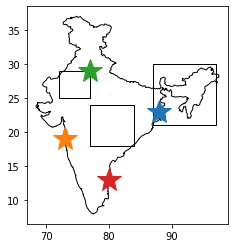

In [145]:
from geopy.geocoders import Nominatim

def getclosest_ij(lats,lons,latpt,lonpt):
    dis_sq1=(lats-latpt)**2
    dis_sq2=(lons-lonpt)**2
    
    minidex_lat=dis_sq1.argmin()
    minidex_lon=dis_sq2.argmin()
    
    return minidex_lon,minidex_lat

func = ii.R20mm_annualy




data_to_indices_spatial = [imd_train,data_gf_test,bcsd_gcm_test,data_gf_future,bcsd_gcm_future]
data_indices_all = []
for data_input in data_to_indices_spatial:
    data_to_indices = []
    for address in ['Kolkata','Mumbai','New Delhi', 'Chennai']:
        geolocator = Nominatim(user_agent="Your_Name")
        location = geolocator.geocode(address)
        [ind_lon,ind_lat] = getclosest_ij(lat_obs.data,lon_obs.data,location.latitude,location.longitude)

        data_to_indices.append(data_input[:, ind_lat,ind_lon])


    regional_boxes = [[72,29,77,25],[77,24,84,18],[87,30,97,21]]

    for co_ords in regional_boxes:

        lat_index_123 = np.logical_and(lat_obs >= co_ords[3], lat_obs <= co_ords[1])
        lon_index_123 = np.logical_and(lon_obs >= co_ords[0], lon_obs <= co_ords[2])

        data_to_indices.append(np.nanmean(data_input[:, lat_index_123,:][:,:,lon_index_123],axis=(1,2)))

    data_to_indices.append(np.nanmean(data_input,axis=(1,2)))
    
    
    data_to_indices_label  =  ['Kolkata', 'Mumbai', 'New Delhi' , 'Chennai' , 'Western India', 'Central India' , 'NE India']
    data_indices = {}
    for data_temp in data_to_indices:
        for index_name in ["R20mm","Rx1day", "CDD","R99p"]:
            data_indices[index_name] =[]   
        
        for index_name,func in zip(["R20mm","Rx1day", "CDD","R99p"],
                                   [ii.R20mm_annualy,ii.Rx1day_annualy,ii.CDD_annualy,ii.R99p_annualy]):
        
            data_indices[index_name].append(np.nanmean(func(data_temp,data_temp.shape[0]//365)))
        
    data_indices_all.append(data_indices)

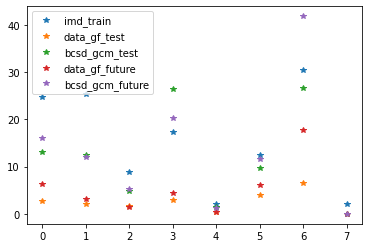

In [142]:
data_labels = ['imd_train','data_gf_test','bcsd_gcm_test','data_gf_future','bcsd_gcm_future']

for i in range(5):
    plt.plot(np.array(data_indices_all)[i],marker ='*',linestyle = 'none',label = data_labels[i] )
plt.legend()